In [13]:
from dataset import NLI_Dataset
from model import MLPNLIModel
from transformers import AutoConfig, AutoTokenizer, AutoModel
from pipeline import Pipeline
import torch

from torch.utils.data import Dataset
import torch.nn as nn

In [7]:
from datasets import load_dataset
snli = load_dataset("snli")
snli = snli.filter(lambda example: example['label'] != -1) 

# 0 : entails
# 1 : neutral
# 2 : contradicts

# Finetuning

## Loading and preprocessing the data

The premise and the hypothesis will be fowarded to the tokenizer, which will return the input_ids, the attention_mask and potentially the token_type_ids. The input_ids are the tokenized version of the premise and the hypothesis, the attention_mask is a binary tensor that indicates which tokens should be attended to and which should not, and the token_type_ids are used to distinguish between the premise and the hypothesis.

Special tokens are already used by the tokenizer, so we don't need to add them manually. Some of them add one separator token between the premise and the hypothesis, while others add two. The `add_special_tokens` parameter of the tokenizer is set to `True` by default, so we don't need to set it manually.

We keep the padding to False and the truncation to True, max_length being set to '512'. The padding is set when collating the data to save memory, and the truncation is set to True because the model can only handle sequences of a certain length.

In [8]:
model_name = 'roberta-large'
config = {
    "model": {
        "name": "roberta-large",
        "num_labels": 3,
        "model_cfg": {
            "hidden_sizes": []
        }
    }
}
model_cfg = config["model"]["model_cfg"]
model_ckpt = "ckpt/roberta-large_20240327_174024.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)

Some models don't have the necessary `special tokens`, we can add them manually :

In [9]:
if "gpt2" in model_name.lower():
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    tokenizer.add_special_tokens({'cls_token': '[CLS]'})
    tokenizer.add_special_tokens({'sep_token': '[SEP]'})

In [10]:
def preprocess_data(examples):
    if "gpt2" in config["model"]["name"]:
        premises = ["[CLS] " + example for example in examples['premise']]
        hypotheses = ["[SEP] " + example + "[SEP]" for example in examples['hypothesis']]
    else:
        premises = [example for example in examples['premise']]
        hypotheses = [example for example in examples['hypothesis']]
    return tokenizer(premises, hypotheses, padding=False, truncation=True, max_length=512)

We then map the whole dataset to the tokenizer. Then, we create a custom Dataset class for the finetuning, which will return the `input_ids`, the `attention_mask`, (potentially) the `token_type_ids` (the whole as a dict) and the `label`. The label is the target of the model, which is the entailment of the hypothesis given the premise. The label is an integer, with 0 being entailment, 1 being neutral and 2 being contradiction.

For this version of the dataset, we decide to tokenize just when we need to access the data, in the ``__getitem__`` method of the NLIDataset class. This way, we can avoid tokenizing the entire dataset at once.

But, this means dealing with the way the dataloader collate the data, so we design a custom function aswell.

We also thought about making some ``data augmentation`` to the dataset, indead, we think that the ``premise`` and the ``hypothesis`` can be swapped. The model should actually be able to predict the same label no matter the order of the premise and the hypothesis. We will add this data augmentation to the dataset but we will try to train with and without it to see if it improves the model's performance.

In [11]:
class NLIDataset(Dataset):
    def __init__(self, dataset, tokenizer, split = 'train', size: int = None, augmentation = False, force_augmentation = False):
        self.tokenizer = tokenizer

        if size is None:
            size = len(dataset[split])
        self.premise = dataset[split]['premise'][:size]
        self.hypothesis = dataset[split]['hypothesis'][:size]
        self.labels = dataset[split]['label'][:size]

        self.augmentation = augmentation
        self.force_augmentation = force_augmentation
    
    def __len__(self):
        return len(self.premise)

    def __getitem__(self, idx):
        premise = self.premise[idx]
        hypothesis = self.hypothesis[idx]
        label = self.labels[idx]

        if self.augmentation and (torch.rand(1) > 0.5 or self.force_augmentation):
            # Swap the premise and hypothesis
            premise, hypothesis = hypothesis, premise

        inputs = self.tokenizer(premise, hypothesis, padding = 'max_length', truncation = True, max_length = 128, return_tensors = 'pt')
        return inputs, label

def custom_collate_fn_nli(batch):
    # Initialize the keys
    inputs = {k: None for k in batch[0][0].keys()}
    labels = None

    for example in batch:
        for k in example[0].keys():
            if inputs[k] is None:
                inputs[k] = example[0][k]
                labels = torch.tensor([example[1]])
            else:
                inputs[k] = torch.cat((inputs[k], example[0][k]), dim = 0)
                labels = torch.cat((labels, torch.tensor([example[1]])), dim = 0)
    return inputs, labels

## Designing the model

We needed to create a base class to test any ``transformer`` model from huggingface. This model would also include a ``classifier`` that would take the first output of the ``last hidden state`` (we could choose take take the pooled output instead) and pass it through a ``linear layer`` to get the logits. Even though we didn't use it, we can use any MLP model as a classifier.

In [14]:
class MLPNLIModel(nn.Module):
    def __init__(self, model_name, model_cfg):
        super(MLPNLIModel, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        # nb_layers being the number of hidden sizes provided in the cgf : 
        # [768, 512, 256] -> 3 layers
        nb_layers = len(model_cfg["hidden_sizes"])
        if nb_layers == 0:
            self.classifier = nn.Linear(self.transformer.config.hidden_size, 3)
        else:
            self.classifier = nn.Sequential(
                nn.Linear(self.transformer.config.hidden_size, model_cfg["hidden_sizes"][0]),
                nn.ReLU(),
                *[nn.Sequential(
                    nn.Linear(model_cfg["hidden_sizes"][i], model_cfg["hidden_sizes"][i+1]),
                    nn.ReLU()
                ) for i in range(nb_layers-1)],
                nn.Linear(model_cfg["hidden_sizes"][-1], 3)
            )
    def forward(self, inputs):
        outputs = self.transformer(**inputs)
        hidden_state = outputs[0]
        pooled_output = hidden_state[:, 0]
        logits = self.classifier(pooled_output)
        return logits

By designing the class this way, the model works even though the different tokenizer we test return different kind of outputs : some return the token_type_ids, some don't...

For the loss and metric, we obviously look at the ``CrossEntropyLoss`` and the ``accuracy``.

## Results and performances

With the different scripts : 
- ``main.py`` (python3 main.py --mode train/test)
- ``utils.py``
- ``model.py``
- ``dataset.py``

We were able to try several transformer models from huggingface to do a small benchmark. We tried the ``bert-base/large-uncased``, the ``roberta-base/large``, the ``distilbert-base-uncased``, the ``TinyBERT_General_4L_312D`` (from huawei) and the ``deberta-v3-large``.

In [4]:
bert-large-uncased : 91.36% (test)
roberta-large : 92.28% (test)


SyntaxError: illegal target for annotation (1311480734.py, line 1)

//Format the performances : 
- BERT (large) : 91.36% (test)
- RoBERTa (large) : 92.28% (test)

# Analysis

## Playground

In order to test efficiently the models, we designed a ``Pipeline`` object that takes a tokenizer and a model when instanciated. This could be called using two sentences, the ``premise`` and the ``hypothesis``, and would return the ``entailment`` of the hypothesis given the premise.

(``pipeline.py``)

In [15]:
class Pipeline():
    def __init__(
            self,
            tokenizer: AutoTokenizer,
            model: MLPNLIModel,
            ):
        self.tokenizer = tokenizer
        self.model = model

    def __call__(
            self,
            premise: str,
            hypothesis: str,
            ):
        return self.predict(premise, hypothesis)

    def predict_proba(
            self,
            premise: str,
            hypothesis: str,
            ):
        inputs = self.tokenizer(premise, hypothesis, return_tensors="pt")
        outputs = self.model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        return probs

    def predict(
            self, 
            premise: str, 
            hypothesis: str
            ):
        probs = self.predict_proba(premise, hypothesis)
        label = probs.argmax().item()
        if label == 0:
            return "entailment"
        elif label == 1:
            return "neutral"
        elif label == 2:
            return "contradiction"
        else:
            return "unknown"

In [16]:
model_name = 'roberta-large'
model_cfg = {"hidden_sizes": []}
model_ckpt = "ckpt/roberta-large_20240327_174024.pth"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MLPNLIModel(model_name, model_cfg)
model.load_state_dict(torch.load(model_ckpt))
pipeline = Pipeline(tokenizer, model)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Here are several examples of the predictions of the models :

In [ ]:
pipeline("The adventurer sees a polar bear", "He is in the north pole")
pipeline("The adventurer sees a polar bear on the ice floe", "He is in the north pole")
pipeline("John is a student at Harvard University", "John is a student")
pipeline("John is a student at Stanford University", "John is good at computer science")
pipeline("Sarah has three children, two boys and one girl", "Sarah has atleast one child")
pipeline("Tom is vegetarian", "Tom does not eat meat")
pipeline("Tom has bought a Ferrari", "Tom is rich")
pipeline("Tom has bought a Ferrari", "Tom is poor")
pipeline("Jason has won ping pong championship", "Jason has practiced a lot")
pipeline("I am going to the beach", "It's raining outside")

In [28]:
print(f"The sky is blue. and A bird is flying. entailment : {pipeline('The sky is blue.', 'A bird is flying.')}")
print(f"The adventurer sees a polar bear. He is in the north pole. entailment : {pipeline('The adventurer sees a polar bear', 'He is in the north pole')}")
print(f"The adventurer sees a polar bear on the ice floe. He is in the north pole. entailment : {pipeline('The adventurer sees a polar bear on the ice floe', 'He is in the north pole')}")
print(f"John is a student at Harvard University. John is a student. entailment : {pipeline('John is a student at Harvard University', 'John is a student')}")
print(f"John is a student at Stanford University. John is good at computer science. entailment : {pipeline('John is a student at Stanford University', 'John is good at computer science')}")
print(f"Sarah has three children, two boys and one girl. Sarah has atleast one child. entailment : {pipeline('Sarah has three children, two boys and one girl', 'Sarah has atleast one child')}")
print(f"Tom is vegetarian. Tom does not eat meat. entailment : {pipeline('Tom is vegetarian', 'Tom does not eat meat')}")
print(f"Tom has bought a Ferrari. Tom is rich. entailment : {pipeline('Tom has bought a Ferrari', 'Tom is rich')}")
print(f"Tom has bought a Ferrari. Tom is poor. entailment : {pipeline('Tom has bought a Ferrari', 'Tom is poor')}")
print(f"Jason has won ping pong championship. Jason has practiced a lot. entailment : {pipeline('Jason has won ping pong championship', 'Jason has practiced a lot')}")
print("I am going to the beach. It's raining outside. entailment :", pipeline("I am going to the beach", "It's raining outside"))
print(f"The cat is sleeping on the couch. The cat is tired. entailment : {pipeline('The cat is sleeping on the couch', 'The cat is tired')}")
print(f"Mary is reading a book. Mary is a teacher. entailment : {pipeline('Mary is reading a book', 'Mary is a teacher')}")
print(f"The team won the football match. The team is happy. entailment : {pipeline('The team won the football match', 'The team is happy')}")
print(f"The flowers are blooming. It is spring. entailment : {pipeline('The flowers are blooming', 'It is spring')}")
print(f"The car has a flat tire. The car is broken down. entailment : {pipeline('The car has a flat tire', 'The car is broken down')}")
print(f"The baby is crying. The baby is hungry. entailment : {pipeline('The baby is crying', 'The baby is hungry')}")
print(f"The man is mowing the lawn. It is summer. entailment : {pipeline('The man is mowing the lawn', 'It is summer')}")
print(f"The woman is shopping for groceries. The woman is a chef. entailment : {pipeline('The woman is shopping for groceries', 'The woman is a chef')}")
print(f"The dog is chasing its tail. The dog is playful. entailment : {pipeline('The dog is chasing its tail', 'The dog is playful')}")
print(f"The sun is setting. It is evening. entailment : {pipeline('The sun is setting', 'It is evening')}")
print(f"The sun is shining. It is a beautiful day. entailment : {pipeline('The sun is shining', 'It is a beautiful day')}")
print(f"The dog is barking. There is a stranger outside. entailment : {pipeline('The dog is barking', 'There is a stranger outside')}")
print(f"The phone is ringing. Someone is calling. entailment : {pipeline('The phone is ringing', 'Someone is calling')}")
print(f"The light is on. The room is not dark. entailment : {pipeline('The light is on', 'The room is not dark')}")


The sky is blue. and A bird is flying. entailment : neutral
The adventurer sees a polar bear. He is in the north pole. entailment : neutral
The adventurer sees a polar bear on the ice floe. He is in the north pole. entailment : neutral
John is a student at Harvard University. John is a student. entailment : entailment
John is a student at Stanford University. John is good at computer science. entailment : neutral
Sarah has three children, two boys and one girl. Sarah has atleast one child. entailment : entailment
Tom is vegetarian. Tom does not eat meat. entailment : entailment
Tom has bought a Ferrari. Tom is rich. entailment : neutral
Tom has bought a Ferrari. Tom is poor. entailment : neutral
Jason has won ping pong championship. Jason has practiced a lot. entailment : neutral
I am going to the beach. It's raining outside. entailment : contradiction
The cat is sleeping on the couch. The cat is tired. entailment : entailment
Mary is reading a book. Mary is a teacher. entailment : neu

The model output is sometime questionnable, but it catches some logic as we can see in the following examples : 

In [32]:
print(f"The light is on. The room is not dark. entailment : {pipeline('The light is on', 'The room is not dark')}")

print(f"The light is on. The room is dark. entailment : {pipeline('The light is on', 'The room is dark')}")

print(f"The phone is ringing. Someone is calling. entailment : {pipeline('The phone is ringing', 'Someone is calling')}")

print(f"The phone is ringing. Nobody is calling. entailment : {pipeline('The phone is ringing', 'Nobody is calling')}")

The light is on. The room is not dark. entailment : entailment
The light is on. The room is dark. entailment : contradiction
The phone is ringing. Someone is calling. entailment : entailment
The phone is ringing. Nobody is calling. entailment : contradiction


Let's try to swap the premise and the hypothesis :

In [33]:
print(f"The room is dark. The light is off. entailment : {pipeline('The room is dark', 'The light is off')}")
print(f"The room is dark. The light is on. entailment : {pipeline('The room is dark', 'The light is on')}")
print(f"Someone is calling. The phone is ringing. entailment : {pipeline('Someone is calling', 'The phone is ringing')}")
print(f"Nobody is calling. The phone is ringing. entailment : {pipeline('Nobody is calling', 'The phone is ringing')}")

The room is dark. The light is off. entailment : entailment
The room is dark. The light is on. entailment : contradiction
Someone is calling. The phone is ringing. entailment : entailment
Nobody is calling. The phone is ringing. entailment : contradiction


That's pretty accurate !

## Attention

Let's try to visualize attention now

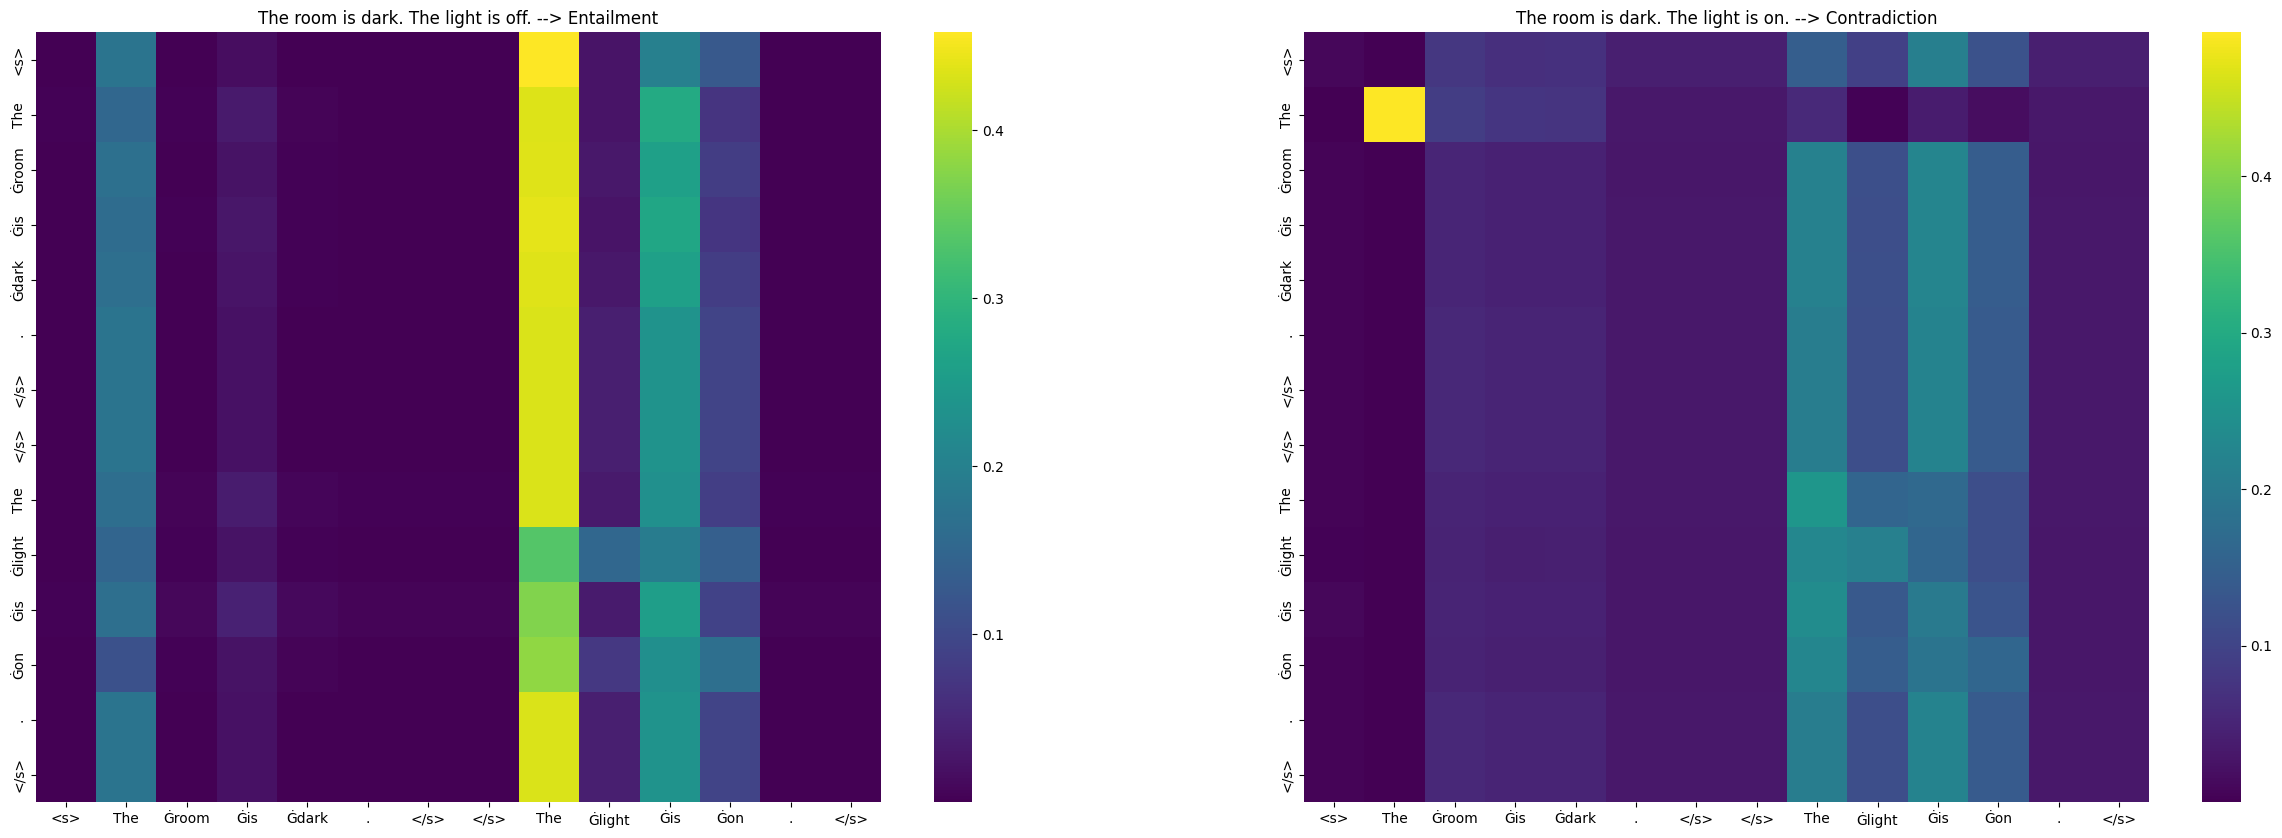

In [40]:
# Visualize the attention on this model : 
# The adventurer sees a polar bear on the ice floe
# He is in the north pole

import seaborn as sns
import matplotlib.pyplot as plt

premise = "The room is dark."
hypothesis = "The light is off."
inputs = tokenizer(premise, hypothesis, return_tensors="pt")
outputs = model.transformer(**inputs, output_attentions=True, return_dict=True)

attn = outputs.attentions[-1].detach().numpy()
sum_attn1 = attn[0].mean(axis=0)
# sum_attn = attn[0, 9]

premise = "The room is dark."
hypothesis = "The light is on."
inputs = tokenizer(premise, hypothesis, return_tensors="pt")
outputs = model.transformer(**inputs, output_attentions=True, return_dict=True)

attn = outputs.attentions[-1].detach().numpy()
sum_attn2 = attn[0].mean(axis=0)



# Same but plot both aside
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
sns.heatmap(sum_attn1, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
plt.title("The room is dark. The light is off. --> Entailment")
plt.subplot(1, 2, 2)
sns.heatmap(sum_attn2, cmap='viridis', xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
plt.title("The room is dark. The light is on. --> Contradiction")
plt.show()

The mean of the attention heads is hardly interpretable ...